In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import genjax
import jax
import jax.numpy as jnp 
from b3d.utils import keysplit
from b3d.camera import Intrinsics, screen_from_camera
from b3d.pose import Pose, camera_from_position_and_target
from b3d.pose_utils import uniform_pose


key = jax.random.PRNGKey(0)

In [4]:
from b3d.gps_utils import add_dummy_var


p0 = Pose.identity()
args = (p0, 2., 0.5)
dummy_mapped_uniform_pose = genjax.map_combinator(in_axes=(0,None,None,None))(add_dummy_var(uniform_pose))

dummy_mapped_uniform_pose.simulate(key, (jnp.arange(4), *args));

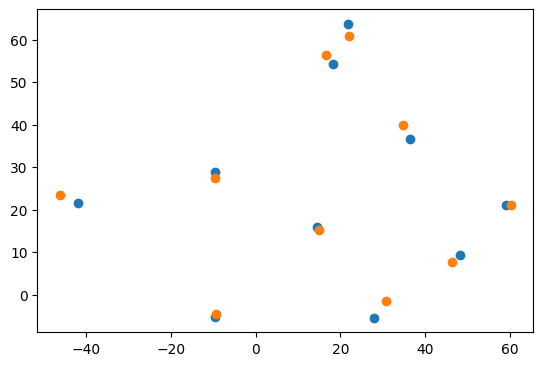

In [5]:
from b3d.sparse_gps_model import minimal_observation_model
from b3d.camera import screen_from_world


T = 2
N = 10

key = keysplit(key)
vis = jax.random.randint(key, (N,), 0, 1).astype(bool)

key, keys = keysplit(key, 1, N)
p0 = Pose.id()
ps = jax.vmap(uniform_pose.sample, (0,None,None,None))(keys, p0, 1., 0.1)

cam = Pose.from_pos(jnp.array([0.,0.,-2.]))
intr = Intrinsics(20,20,100.,100.,10.,10.,0.1e-3,1e3)
sigma = 2.

key = keysplit(key)
tr = minimal_observation_model.simulate(key, (vis, ps, cam, intr, sigma));
uv_ = tr.get_retval()
uv = screen_from_world(ps.pos, cam, intr)
# ==============================
plt.gca().set_aspect(1)
plt.scatter(*uv.T)
plt.scatter(*uv_.T)

In [6]:
from b3d.sparse_gps_model import make_sparse_gps_model
help(make_sparse_gps_model)

Help on function make_sparse_gps_model in module b3d.sparse_gps_model:

make_sparse_gps_model(T, N, K, F, particle_pose_prior, particle_pose_prior_args, object_pose_prior, object_pose_prior_args, camera_pose_prior, camera_pose_prior_args, observation_model, observation_model_args, object_motion_model, object_motion_model_args, camera_motion_model, camera_motion_model_args, visibility_model, visibility_model_args)
    Models independently moving rigid object as clusters of
    Gaussians which specify the position, pose, and uncertainty of 3d keypoints in space.
    
    For simplicity we assume that keypoints can only emit a single constant feature,
    that we may interpret as a "point light".
    
    We can easily extend this model to handle feature vectors.
    
    Args:
        `T`: Number of time steps
        `N`: Number of particles
        `K`: Number of object clusters
        `F`: Feature dimension
        `particle_pose_prior`: Particle pose model `(nums: Array, *args) -> p

In [7]:
logit = jax.scipy.special.logit

In [8]:
key, keys = keysplit(key, 1, 10_000)
jax.vmap(lambda key: genjax.bernoulli.sample(key, logit(0.5)))(keys).sum()

Array(5059, dtype=int32)

In [9]:
intr = Intrinsics(100, 50, 100., 100., 50., 25., 1e-6, 100.)
outlier_prob = 0.0

p0 = Pose.identity()
particle_pose_prior = dummy_mapped_uniform_pose
particle_pose_prior_args = (p0, .5, 0.25)

object_pose_prior = dummy_mapped_uniform_pose
object_pose_prior_args = (p0, 2., 0.5)

camera_pose_prior = uniform_pose
camera_pose_prior_args = (p0, 0.1, 0.1)

observation_model = minimal_observation_model
observation_model_args = (2.,)

object_motion_model = genjax.map_combinator(in_axes=(0,None,None))(uniform_pose)
object_motion_model_args = (0.1, 0.1)

camera_motion_model = uniform_pose
camera_motion_model_args = (0.1, 0.2)

In [25]:
T,N,K = 2, 3, 3
F = 0
maker_args = (
    T,N,K,F,
    particle_pose_prior,
    particle_pose_prior_args,
    object_pose_prior,
    object_pose_prior_args,
    camera_pose_prior,
    camera_pose_prior_args,
    observation_model,
    observation_model_args,
    object_motion_model,
    object_motion_model_args,
    camera_motion_model,
    camera_motion_model_args
)
model = make_sparse_gps_model(*maker_args)
jimportance = jax.jit(model.importance)
jsimulate = jax.jit(model.simulate)

In [26]:
tr = jsimulate(key, (intr,))